In [1]:
# !pip install squarify

In [52]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import re

In [53]:
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

In [ ]:
df = pd.read_csv("../../../서울특별시_일반음식점.csv", encoding="cp949")
# 현재 필요 없는 컬럼 삭제
df.drop(columns=["Unnamed: 47",
                 "개방서비스아이디",
                 "개방자치단체코드",
                 "관리번호",
                 "인허가일자",
                 "인허가취소일자",
                 "상세영업상태코드",
                 "소재지전화",
                 "공장판매직종업원수",
                 "공장생산직종업원수",
                 "건물소유구분명",
                 "보증액",
                 "월세액",
                 "다중이용업소여부",
                 "시설총규모",
                 "전통업소지정번호",
                 "전통업소주된음식",
                 "홈페이지",
                 "남성종사자수",
                 "여성종사자수",
                 "영업장주변구분명",
                 "등급구분명",
                 "급수시설구분명",
                 "총종업원수",
                 "본사종업원수",
                 "공장사무직종업원수",
                 "소재지면적",
                 "최종수정시점",
                 "데이터갱신구분",
                 "데이터갱신일자",
                 "번호",
                 "도로명우편번호",
                 "소재지우편번호",
                 "개방서비스명"
                 ],inplace=True)
# 폐업 후 재개업 하지 않은 음식점 삭제
df.drop(index=(df[(df["폐업일자"].notna()) & (df["재개업일자"].isnull())].index),inplace=True)
# 정상 영업하는 가게의 해당 컬럼들은 의미 없으므로 삭제
print(df["폐업일자"].notna().sum())
print(df["휴업시작일자"].notna().sum())
print(df["휴업종료일자"].notna().sum())
print(df["재개업일자"].notna().sum())
print(df[df["상세영업상태명"] != "영업"].shape[0])
print(df[df["영업상태명"] != "영업/정상"].shape[0])
df.drop(columns=["폐업일자","휴업시작일자","휴업종료일자","재개업일자","상세영업상태명","영업상태구분코드","영업상태명"],inplace=True)

# 사업자명이 null값이 아니면서 치킨이 포함되는 음식점이거나 업태구분명, 위생업태명에 통닭이 포함되는 업체만 출력
df = df[(df["사업장명"].notna()) & (df["사업장명"].str.contains("치킨")) | (df["업태구분명"].str.contains("통닭")) | (df["위생업태명"].str.contains("통닭"))].reset_index(drop=True)
# 도로명전체주소 컬럼에서 구를 추출
def find_address_gu(address):
    words = address.split()  # 공백 기준으로 나누기
    for word in words:
        if word.endswith('구'):  # "구"로 끝나면 전체 반환
            return word

def find_address_dong(address):
    # 구에 해당하는 단어를 찾기 (구 이름은 반드시 "구"로 끝남)
    match_gu = re.search(r'([가-힣]+구)', address)
    if match_gu:
        # 구 이후 첫 번째 단어 추출
        address_after_gu = address[match_gu.end():]  # 구 이후의 주소 부분

        # 첫 번째 단어 찾기 (공백 기준으로 나누기)
        first_word = address_after_gu.split()[0]

        # 첫 번째 단어가 "동"으로 끝나는지 확인
        if first_word.endswith("동"):
            return first_word

        # 첫 번째 단어가 "가"로 끝나는지 확인
        elif first_word.endswith("가"):
            return first_word
        
        elif first_word.endswith("로"):
            return first_word

    return None  # 동도 없고 "가"도 없으면 None 반환

def find_address_dong2(address):
    words = address.split()  # 주소를 공백 기준으로 나누기
    for word in reversed(words):  # 뒤에서부터 확인
        if "동" in word:  # "동"이 포함된 단어 찾기
            # 괄호와 쉼표 등의 특수 문자 제거
            clean_word = re.sub(r'[^\w가-힣]', '', word)  # 한글과 숫자 외의 모든 문자를 제거
            return clean_word  # 특수문자를 제거한 "동"이 포함된 단어 반환
    return None  # 해당하는 동이 없으면 None 반환

def process_dong(address):

    # 4. "ㅇㅇ1동"과 같은 주소에서 숫자만 제거하여 "ㅇㅇ동"으로 출력
    if "동" in address and re.search(r'\d+동$', address):  # "동" 뒤에 숫자가 있는 경우
        return re.sub(r'\d+(?=동)', '', address)  # "동" 앞의 숫자만 제거
    
    # 1. "동"으로 끝나는 주소는 그대로 동을 유지
    if address.endswith("동"):
        return address
    
    # 2. "동"을 포함하고 있고 뒤에 숫자+가가 있으면 "동"까지 추출
    if "동" in address and re.search(r'\d+가$', address):  # 숫자+가로 끝나면
        return re.sub(r'\d+가$', '', address)  # "1가"만 제거하고 "동"까지만 남김
    
    # 3. "1가"와 같은 숫자만 제거하고 "가"만 남기
    if re.search(r'\d+가$', address):
        return re.sub(r'\d+', '', address)  # 숫자만 제거하여 "ㅇㅇㅇ가" 형식으로 만듬
    
    # 5. "동ㅇ동1가"와 같은 경우 "동ㅇ동"으로 출력
    if re.search(r'동.+\d+가$', address):
        address = re.sub(r'\d+가$', '', address)  # "1가"만 제거하여 "동ㅇ동" 형식으로 만듬

    return address

# "구" 값 초기화
df["구"] = None

# 도로명전체주소에서 구 추출
df.loc[df['도로명전체주소'].notna(), "구"] = df.loc[df['도로명전체주소'].notna(), "도로명전체주소"].apply(find_address_gu)

# 소재지전체주소에서 구 추출 (도로명전체주소가 NaN인 경우만 업데이트)
df.loc[df['소재지전체주소'].notna() & df["구"].isna(), "구"] = df.loc[df['소재지전체주소'].notna(), "소재지전체주소"].apply(find_address_gu)

for gu in df["구"].dropna().unique():
    df.loc[(df["구"] == gu) & (df["소재지전체주소"].notna()), "동"] = df.loc[(df["구"] == gu) & (df["소재지전체주소"].notna()), "소재지전체주소"].apply(find_address_dong)
df.loc[df["동"].isna(), "동"] = df[df["동"].isna()]["도로명전체주소"].apply(find_address_dong2)
df.loc[:,"동"] = df.loc[:,"동"].apply(process_dong)

C:\Users\lth08\AppData\Local\Temp\ipykernel_10736\3322731166.py:1: DtypeWarning: Columns (22,27,39,41,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../../서울특별시_일반음식점.csv", encoding="cp949")


0
0
0
0
0
0


In [256]:
graph_data = df[df["구"] == "동작구"]["동"].value_counts().reset_index()
graph_data

,동,count
0,사당동,141
1,상도동,113
2,노량진동,64
3,흑석동,49
4,대방동,35
5,신대방동,35
6,본동,2


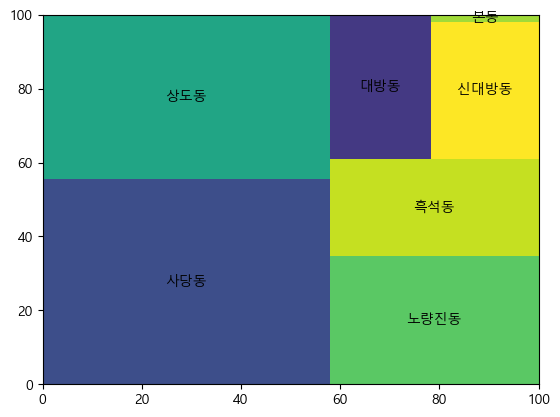

In [257]:
plt.figure()
squarify.plot(sizes=graph_data["count"], label=graph_data["동"])
plt.show()

In [276]:
import folium
import pyproj

In [294]:
df[(df["구"] == "동작구") & (df["좌표정보(x)"].notna())]

,소재지전체주소,도로명전체주소,사업장명,업태구분명,좌표정보(x),좌표정보(y),위생업태명,구,동
52,서울특별시 동작구 상도동 489-7번지,"서울특별시 동작구 상도로 368, 2층 (상도동)",펍캐리온,호프/통닭,195827.063760,443742.61681,호프/통닭,동작구,상도동
74,서울특별시 동작구 사당동 167-19번지 래미안 로이파크,"서울특별시 동작구 사당로23길 112, 후면상가동 B108호 (사당동, 래미안 로이파크)",60계치킨 서울이수점,호프/통닭,197527.637382,442943.750543,호프/통닭,동작구,사당동
80,서울특별시 동작구 사당동 269-23번지,"서울특별시 동작구 사당로16가길 43, 1층 (사당동)",또래오래,호프/통닭,197370.728020,442364.596713,호프/통닭,동작구,사당동
89,서울특별시 동작구 사당동 1029-37,"서울특별시 동작구 사당로30길 96, 1층 (사당동)",청년치킨 사당점,호프/통닭,198221.486615,442037.886575,호프/통닭,동작구,사당동
105,서울특별시 동작구 상도동 210-18,"서울특별시 동작구 양녕로 192, 2층 (상도동)",생선마당어랑,호프/통닭,194959.547614,444004.845129,호프/통닭,동작구,상도동
...,...,...,...,...,...,...,...,...,...
12861,서울특별시 동작구 상도동 499-16번지,"서울특별시 동작구 상도로67길 17, 지하1층, 1층 (상도동)",꿀마니,호프/통닭,196069.708965,443571.284563,호프/통닭,동작구,상도동
13629,서울특별시 동작구 상도1동 739-1,"서울특별시 동작구 상도로38가길 5, 1층 (상도1동)",순수치킨상도점,호프/통닭,195296.078261,444477.122017,호프/통닭,동작구,상도동
14002,서울특별시 동작구 상도동 486-3 준콤숭실빌딩,"서울특별시 동작구 상도로 349-1, 준콤숭실빌딩 1, 2층 (상도동)",60계 서울상도점,호프/통닭,195778.223518,443919.044414,호프/통닭,동작구,상도동
14045,서울특별시 동작구 사당동 269-30,서울특별시 동작구 사당로16가길 42 (사당동),오태식해바라기치킨,호프/통닭,197386.501916,442378.221194,호프/통닭,동작구,사당동


In [289]:
proj_from = pyproj.CRS('EPSG:5181')
proj_to = pyproj.CRS('EPSG:4326')
transformer = pyproj.Transformer.from_crs(proj_from, proj_to, always_xy=True)
x = df[(df["구"] == "동작구") & (df["좌표정보(x)"].notna())]["좌표정보(x)"][74]
y = df[(df["구"] == "동작구") & (df["좌표정보(x)"].notna())]["좌표정보(y)"][74]
longitude, latitude = transformer.transform(x, y)
print(longitude, latitude)

126.97204538661819 37.48593762030535


In [291]:


chicken_map = folium.Map(location=
                         [latitude, longitude],
                          zoom_start=15)
chicken_map